# Ensemble: simpconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.ensemble
import libs.local
import libs.plot
import libs.vars
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

/home/users/woodward/.conda/envs/climate/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## Data

In [2]:
# ----- SPECIFIC SETTINGS -----
component = 'SImon'
experiment = 'ssp585'
variable_id = 'simpconc'

spatial_text = 'sea-ice melt pond concentration'
spatial_units = '%'

conf = [v for v in libs.vars.variables() if v['variable_id'] == variable_id][0]
time_series_text = conf['text']
time_series_weighted_method = conf['weighting_method']
time_series_units = conf['units']
time_series_y_label = f'Concentration ({time_series_units})'
time_series_y_range = (0, 6.5)
time_series_y_range_full = (0, 40)
time_series_y_range_monthly = (0, 50)
time_series_y_range_regional = (0, 42)

# Convert from m2 to km2 and % to fraction
time_series_process = conf['weighting_process']

colormesh_kwargs = {
    'extend': 'neither',
    'levels': 21,
    #'shading': 'auto', # NB change to 'gouraud' if Jaspy
    'vmin': 0,
    'vmax': 50,
    'x': 'longitude', 
    'y': 'latitude'
}

In [3]:
ensemble, weight = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    variable_id
)

ensemble_siconc, weight_siconc = libs.ensemble.get_and_preprocess(
    component, 
    experiment, 
    'siconc'
)

ensemble_time_series = libs.local.get_ensemble_series(variable_id, experiment)

time_slices = libs.vars.default_time_slices()
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask

regions = [r for r in libs.vars.nsidc_regions() if len(r['values']) == 1]

Error 404
-> _data/cmip6/CanESM5/simpconc/simpconc_SImon_CanESM5_ssp585_r1i1p2f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/EC-Earth3/simpconc/simpconc_SImon_EC-Earth3_ssp585_r4i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/IPSL-CM6A-LR/simpconc/simpconc_SImon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MIROC6/simpconc/simpconc_SImon_MIROC6_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MPI-ESM1-2-LR/simpconc/simpconc_SImon_MPI-ESM1-2-LR_ssp585_r1i1p1f1_gn_201501-210012_processed.nc
Error 404
-> _data/cmip6/MRI-ESM2-0/simpconc/simpconc_SImon_MRI-ESM2-0_ssp585_r1i1p1f1_gn_201501-210012_processed.nc


In [4]:
def generate_ts(ensemble, ensemble_mask, time_series_weighted_method, weight, nsidc_mask=None, region=None):
    data_vars = {}

    for i, item in enumerate(ensemble):
        item_mask = [item_mask for item_mask in ensemble_mask if item_mask['label'] == item['label']]
        if len(item_mask) == 0:
            continue

        processed_data = time_series_process(item['data'])
        processed_data = processed_data.where(item_mask[0]['data'] > 15)
        if region != None:
            processed_data = processed_data.where(np.isin(nsidc_mask.values, region['values']))
            processed_data.attrs['region'] = region['label']

        processed_data.attrs['color'] = item['color']
        processed_data = processed_data.drop_vars(['height', 'type'], errors='ignore')

        # Reduce data, i.e. taking sum or average over spatial dimensions
        item_weighted = processed_data.weighted(weight)
        item_reduced = getattr(
            item_weighted, 
            time_series_weighted_method
        )(dim=item_weighted.weights.dims, skipna=True)

        data_vars[item['label']] = item_reduced


    ds = xarray.Dataset(data_vars=data_vars)
    ds = libs.ensemble.calc_variable_mean(ds)

    if region != None:
        ds.attrs['region'] = region['label']
    
    return ds

In [5]:
ts_kwargs = {
    'ensemble': ensemble,
    'ensemble_mask': ensemble_siconc,
    'time_series_weighted_method': time_series_weighted_method,
    'weight': weight
}

ds_ts_all = generate_ts(**ts_kwargs)
arr_ds_regions = [generate_ts(region=r, nsidc_mask=nsidc_mask, **ts_kwargs) for r in regions]

## Time series

### Max / Mean

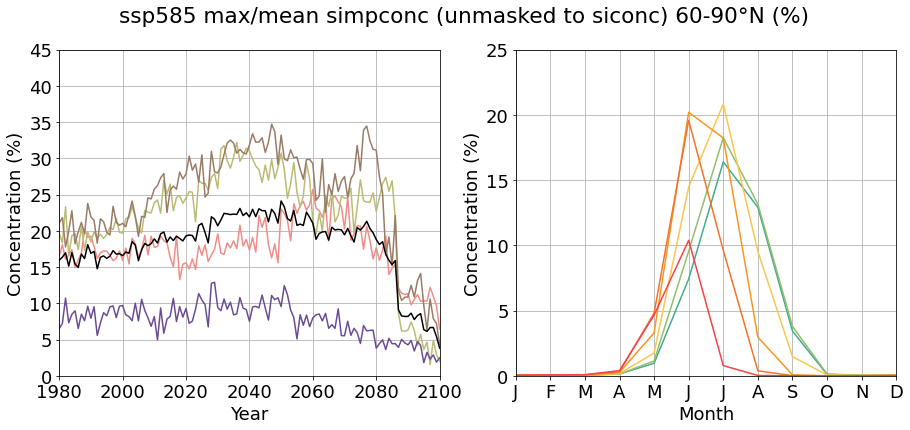

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(f'{experiment} max/mean simpconc (unmasked to siconc) 60-90°N ({time_series_units})')

vars_series = [
    ensemble_time_series
]
plot_arr = []
for item in vars_series:
    item_processed = item.groupby('time.year').max('time') 
    item_processed = libs.ensemble.calc_variable_mean(item_processed)
    plot_arr.append(item_processed)

libs.plot.time_series_from_vars(
    plot_arr,
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 45)
);

arr = []
for s in libs.vars.time_slices_20y():
    s_label = s['label']
    data_slice = ensemble_time_series.sel(**s['slice']).groupby('time.month').mean('time')
    data_slice['Ensemble mean'].attrs['color'] = s['color']
    data_slice['Ensemble mean'].attrs['label'] = s['label']
    arr.append(data_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel=time_series_y_label,
    yrange=(0, 25)
);

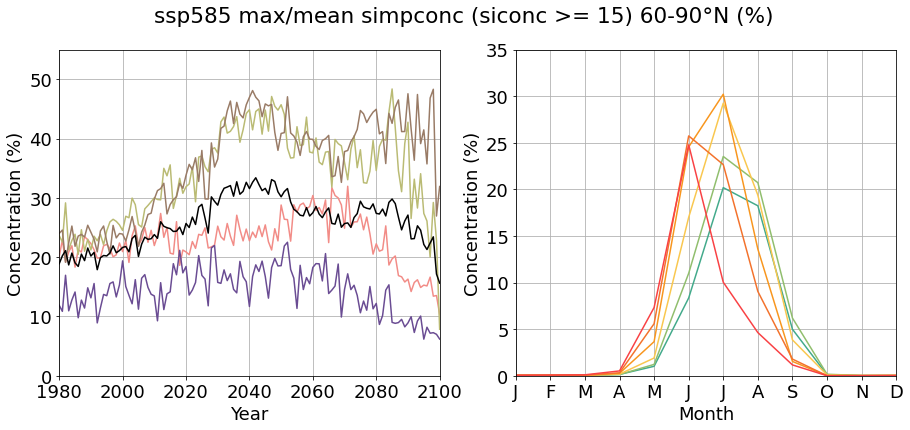

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
fig.suptitle(f'{experiment} max/mean simpconc (siconc >= 15) 60-90°N ({time_series_units})')

ds_max = ds_ts_all.groupby('time.year').max('time')
libs.plot.time_series_from_vars(
    [
        ds_max,
    ],
    ax=axes[0],
    fig=fig,
    show_legend=False,
    xattr='year',
    ylabel=time_series_y_label,
    yrange=(0, 55)
);

arr = []
for s in libs.vars.time_slices_20y():
    s_label = s['label']
    data_slice = ds_ts_all.sel(**s['slice']).groupby('time.month').mean('time')
    data_slice['Ensemble mean'].attrs['color'] = s['color']
    data_slice['Ensemble mean'].attrs['label'] = s['label']
    arr.append(data_slice)

libs.plot.monthly_variability(
    arr,
    ax=axes[1],
    fig=fig,
    legend_below=True,
    show_legend=False,
    variables=['Ensemble mean'],
    ylabel=time_series_y_label,
    yrange=(0, 35)
);

## Monthly variability

### Full region (time)

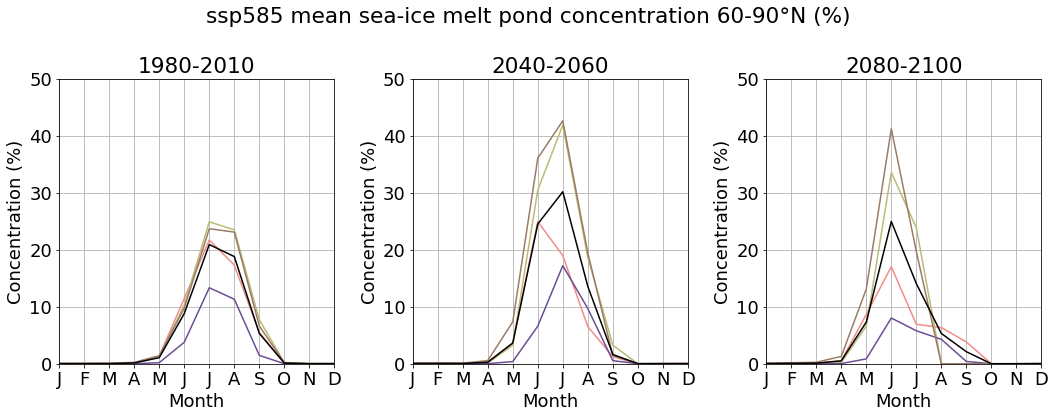

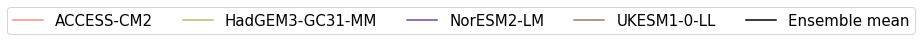

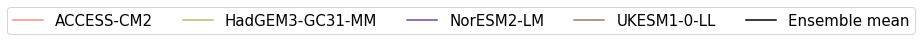

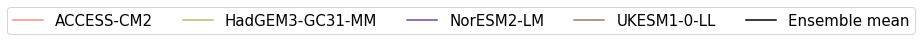

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs = axs.flatten()
fig.suptitle(f'{experiment} mean {time_series_text} 60-90°N ({time_series_units})')

for i, s in enumerate(time_slices):
    s_label = s['label']
    
    time_slice = ds_ts_all.sel(**s['slice']).groupby('time.month').mean('time')
    time_slice = libs.ensemble.calc_variable_mean(time_slice)
    time_slice = time_slice.fillna(0)

    libs.plot.monthly_variability(
        time_slice,
        ax=axs[i],
        fig=fig,
        show_legend=False,
        ylabel=time_series_y_label,
        yrange=time_series_y_range_monthly
    );
    
    axs[i].set_title(s_label)
    

libs.plot.legend_standalone(
    fig,
    legend_confs=[
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 5, 'exclude': [] },
        { 'ncol': 5, 'exclude': [] }
    ]
)

fig.tight_layout()

### Regional sea-ice area (seasonal)

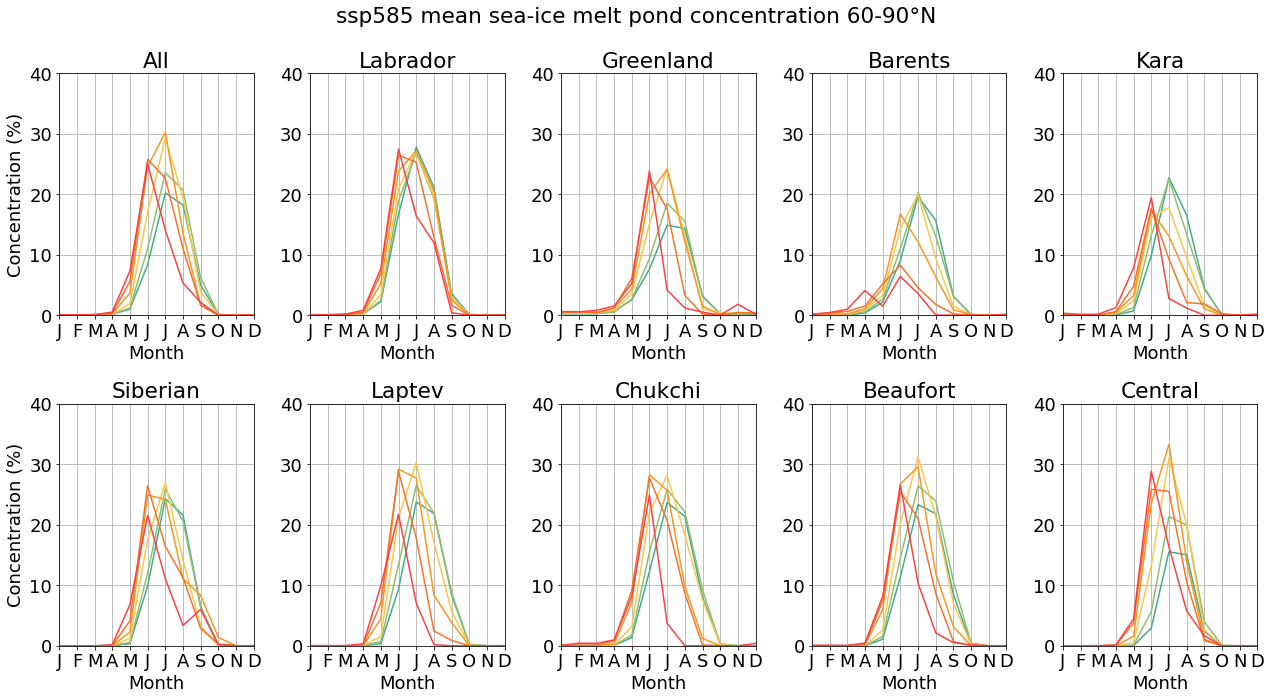

In [9]:
fig, axs = plt.subplots(2, 5, figsize=(18, 10))
axs = axs.flatten()
fig.suptitle(f'{experiment} mean {time_series_text} 60-90°N')

ds_ts_all.attrs['region'] = 'All'

for i, ds_region in enumerate([ds_ts_all, *arr_ds_regions]):
    arr_region = []
    for s in libs.vars.time_slices_20y():
        s_label = s['label']
        data_slice = ds_region.sel(**s['slice']).groupby('time.month').mean('time')
        data_slice = libs.ensemble.calc_variable_mean(data_slice)
        data_slice = data_slice.fillna(0)
        data_slice['Ensemble mean'].attrs['color'] = s['color']
        data_slice['Ensemble mean'].attrs['label'] = s['label']
        arr_region.append(data_slice)
    
    libs.plot.monthly_variability(
        arr_region,
        ax=axs[i],
        fig=fig,
        show_legend=False,
        variables=['Ensemble mean'],
        ylabel=(time_series_y_label if i % 5 == 0 else ''),
        yrange=(0, 40)
    )
    
    axs[i].set_title(ds_region.attrs['region'])
    
fig.tight_layout()

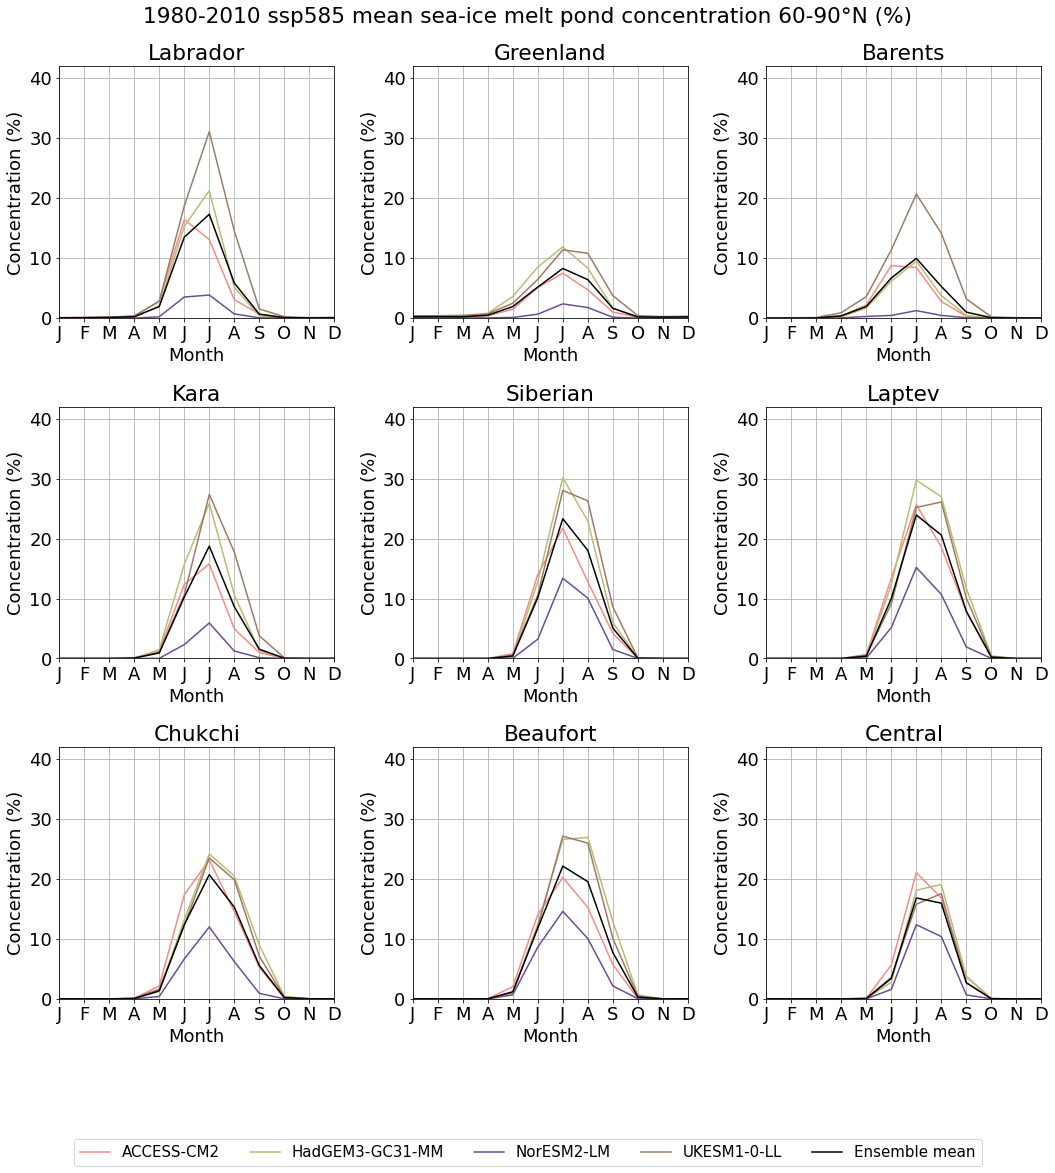

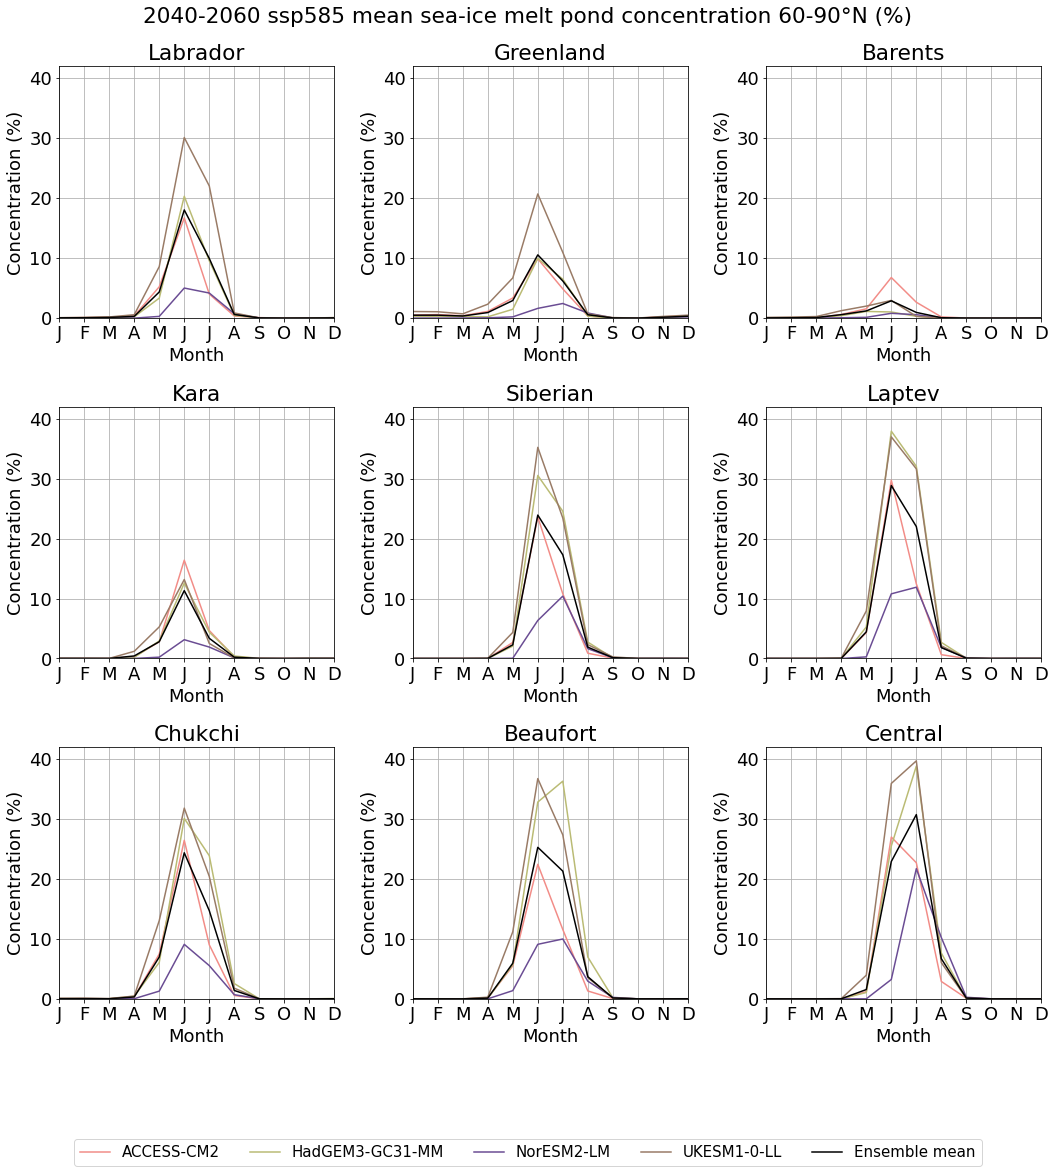

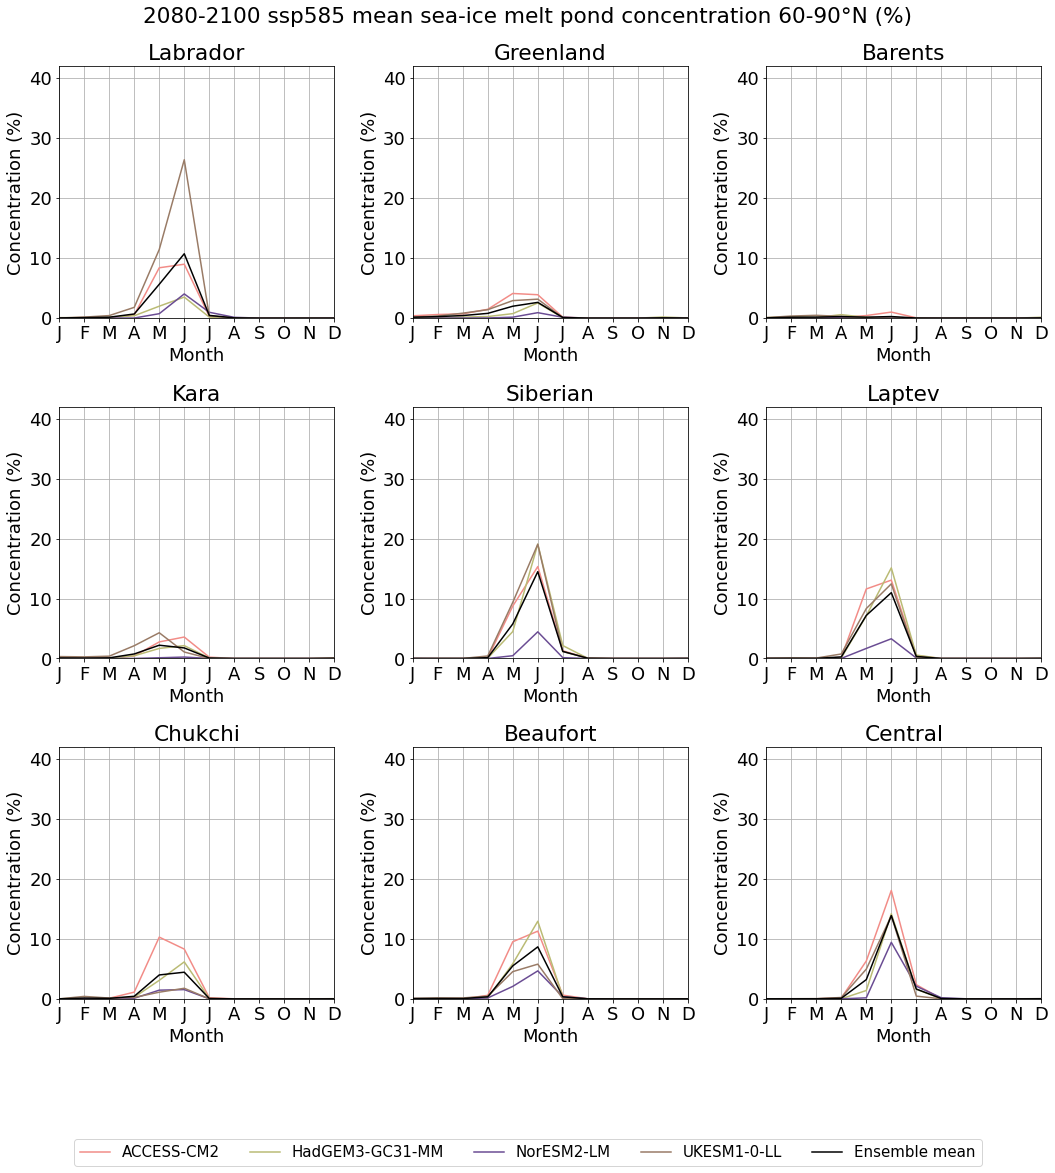

In [10]:
regions = libs.local.get_ensemble_regional_series(variable_id, experiment)

for s in time_slices:
    s_label = s['label']
    regional_time_slices = [
        data.sel(**s['slice']).groupby('time.month').mean('time') for data in regions
    ]

    libs.plot.monthly_variability_regional(
        regional_time_slices,
        title=f'{s_label} {experiment} mean {time_series_text} 60-90°N ({time_series_units})',
        ylabel=time_series_y_label,
        yrange=time_series_y_range_regional
    )

### Spatial

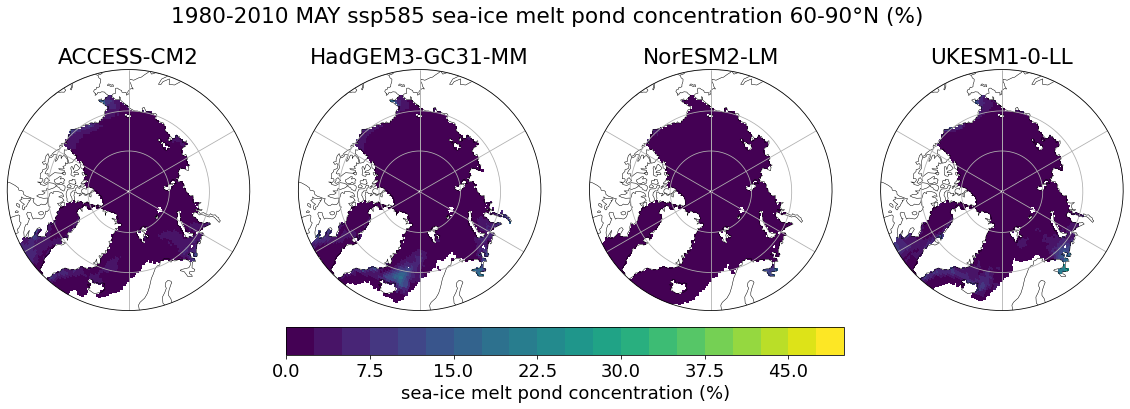

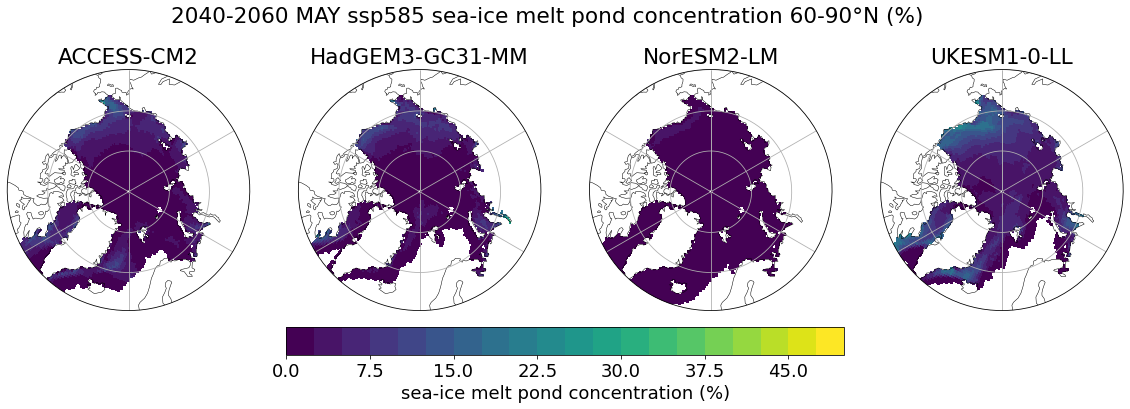

In [11]:
import warnings
warnings.filterwarnings('ignore')

libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='MAY',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

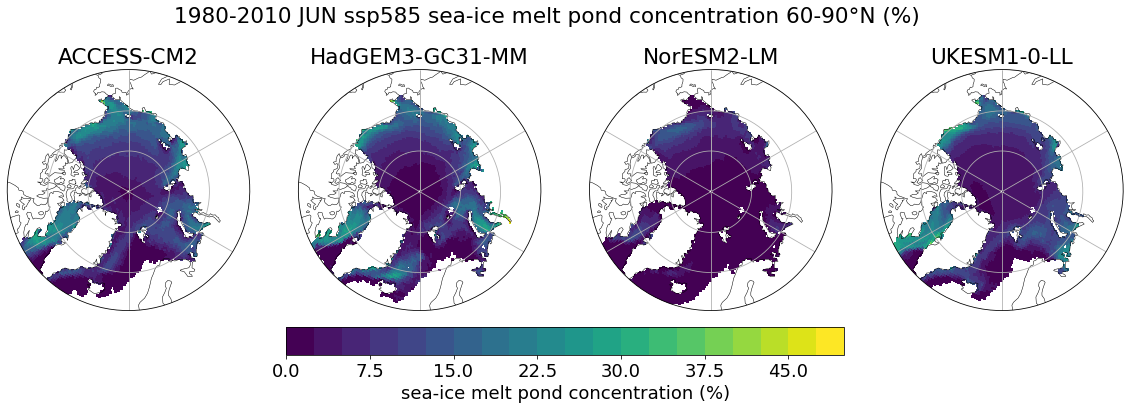

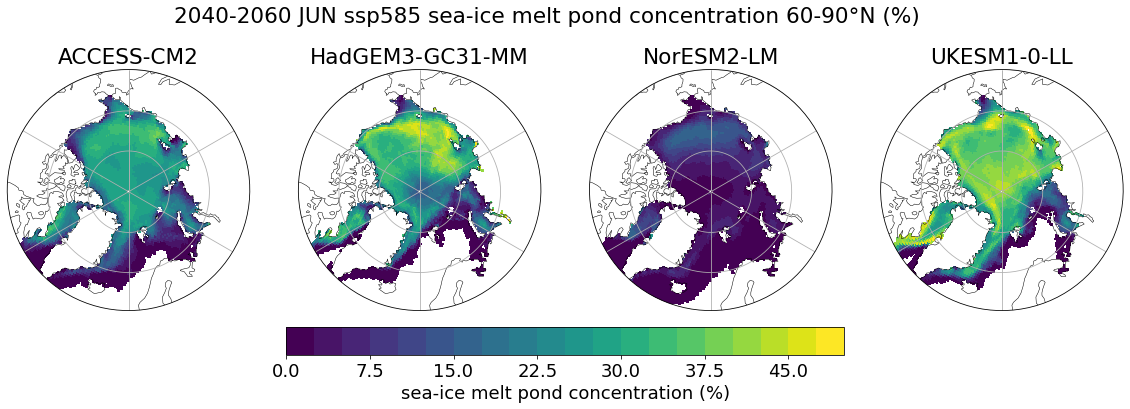

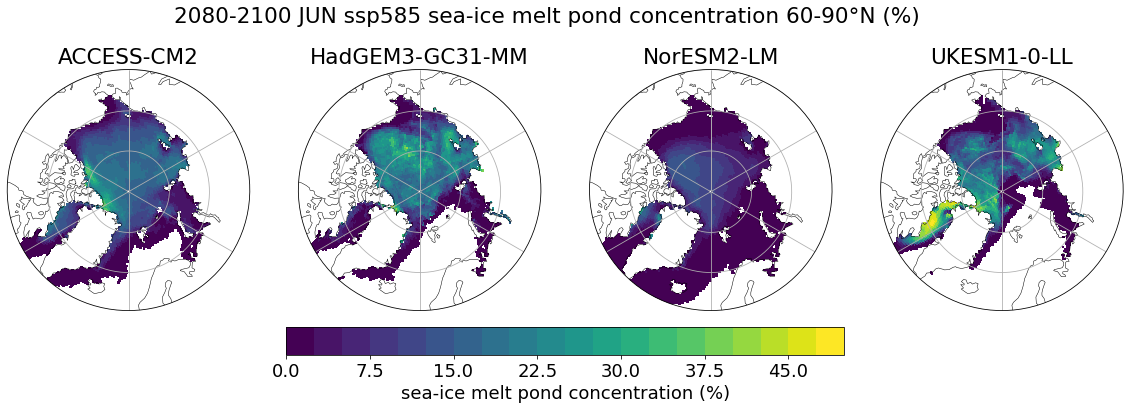

In [12]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='JUN',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

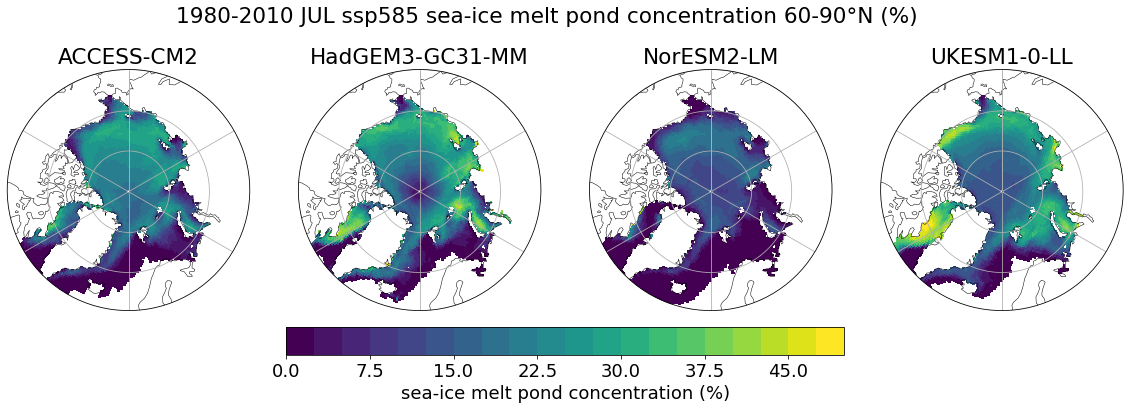

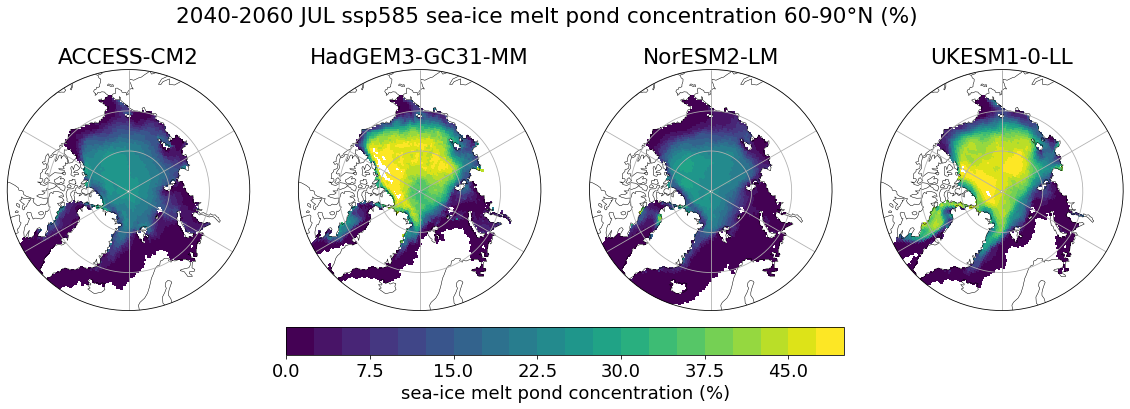

In [13]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='JUL',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)

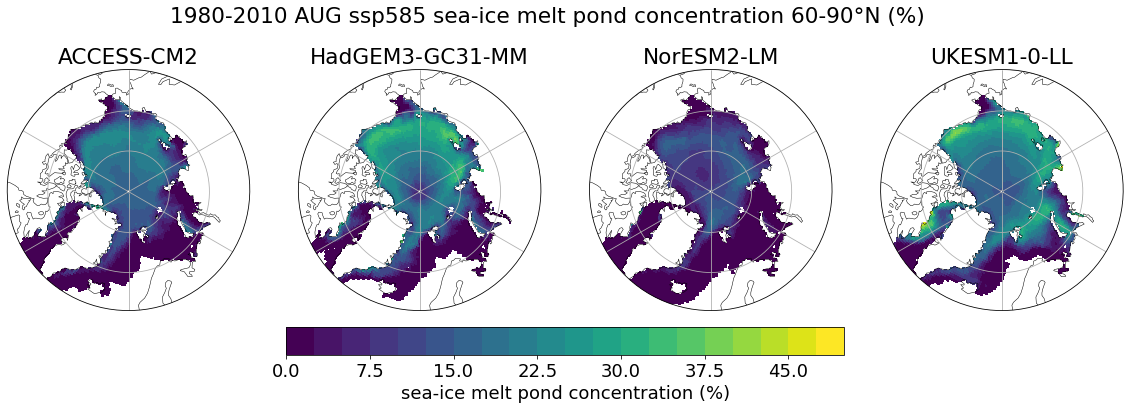

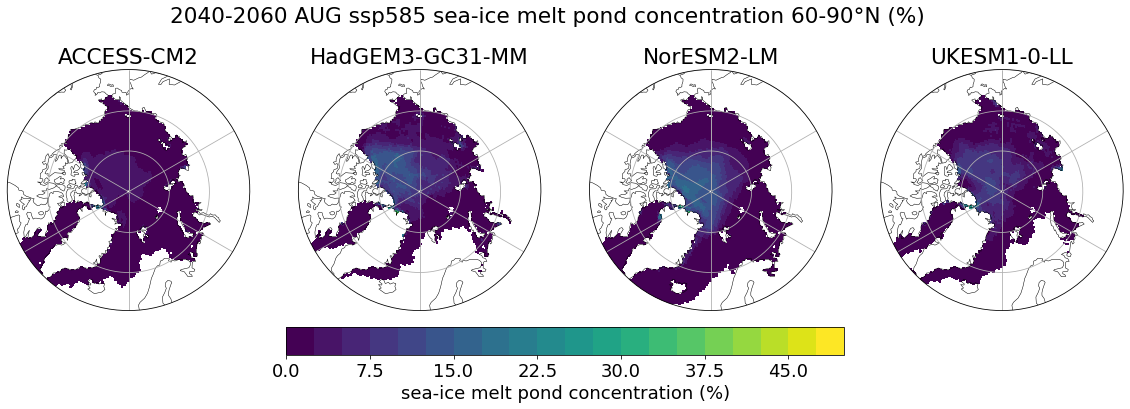

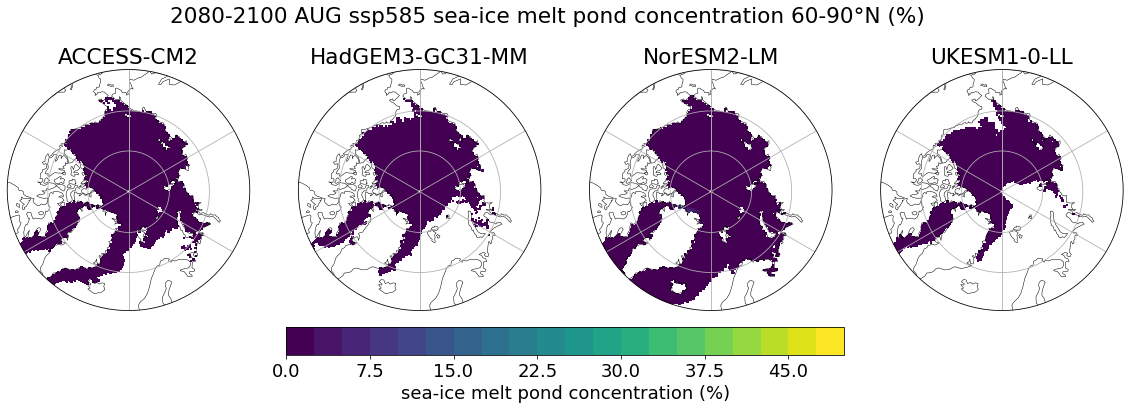

In [14]:
libs.plot.calendar_division_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    text=spatial_text,
    time='AUG',
    title='{label} {time} ssp585 {text} 60-90°N ({units})',
    units=spatial_units
)